**<h1>English To French Machine Translation**




**<h2> Importing Libraries**


In [9]:
import string
import re
import numpy as np
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

**<h2> Importing dataset**

In [10]:
from google.colab import files
uploaded = files.upload()
name=str(list(uploaded.keys())[0])

Saving eng-fra.txt to eng-fra (1).txt


In [11]:
print(name)


eng-fra (1).txt


In [12]:
eng_fra=uploaded[name].decode("utf-8").split('\n')
eng_fra_cpy=eng_fra
eng_fra[:10]

['Go.\tVa !',
 'Run!\tCours\u202f!',
 'Run!\tCourez\u202f!',
 'Wow!\tÇa alors\u202f!',
 'Fire!\tAu feu !',
 "Help!\tÀ l'aide\u202f!",
 'Jump.\tSaute.',
 'Stop!\tÇa suffit\u202f!',
 'Stop!\tStop\u202f!',
 'Stop!\tArrête-toi !']

**<h2>Data Cleaning**

 separate the english and french sentences from each other.

In [13]:
eng_fra=eng_fra[:25000]
eng_fra=[i.split('\t') for i in eng_fra]
eng_fra

[['Go.', 'Va !'],
 ['Run!', 'Cours\u202f!'],
 ['Run!', 'Courez\u202f!'],
 ['Wow!', 'Ça alors\u202f!'],
 ['Fire!', 'Au feu !'],
 ['Help!', "À l'aide\u202f!"],
 ['Jump.', 'Saute.'],
 ['Stop!', 'Ça suffit\u202f!'],
 ['Stop!', 'Stop\u202f!'],
 ['Stop!', 'Arrête-toi !'],
 ['Wait!', 'Attends !'],
 ['Wait!', 'Attendez !'],
 ['I see.', 'Je comprends.'],
 ['I try.', "J'essaye."],
 ['I won!', "J'ai gagné !"],
 ['I won!', "Je l'ai emporté !"],
 ['Oh no!', 'Oh non !'],
 ['Attack!', 'Attaque !'],
 ['Attack!', 'Attaquez !'],
 ['Cheers!', 'Santé !'],
 ['Cheers!', 'À votre santé !'],
 ['Cheers!', 'Merci !'],
 ['Get up.', 'Lève-toi.'],
 ['Got it!', "J'ai pigé !"],
 ['Got it!', 'Compris !'],
 ['Got it?', 'Pigé\u202f?'],
 ['Got it?', 'Compris\u202f?'],
 ['Got it?', "T'as capté\u202f?"],
 ['Hop in.', 'Monte.'],
 ['Hop in.', 'Montez.'],
 ['Hug me.', 'Serre-moi dans tes bras !'],
 ['Hug me.', 'Serrez-moi dans vos bras !'],
 ['I fell.', 'Je suis tombée.'],
 ['I fell.', 'Je suis tombé.'],
 ['I know.', 'Je sai

**<h3> Getting Rid of Punctuation&Unicode,Reducing to lowercase**



In [14]:
eng=[re.sub(r'\s',' ',i[0].lower().translate(str.maketrans('', '', string.punctuation))) for i in eng_fra]
fra=[re.sub(r'\s',' ',i[1].lower().translate(str.maketrans('', '', string.punctuation))) for i in eng_fra]
eng=array(eng)
fra=array(fra)

Now, calculation of the maximum length of a sentence. This will be used as a parameter later.

In [15]:
eng_l=[len(i) for i in eng]
fra_l=[len(i) for i in fra]
eng_max_l=np.asarray(eng_l).max()
fra_max_l=np.asarray(fra_l).max()
print("eng max",eng_max_l,'\n',"fra max",fra_max_l)

eng max 19 
 fra max 54


**<h3>Tokenization**

Next,we'll be tokenizing the sentences. Tokenization reads the given sentences and assigns each distinct word a number.
For eg,if the sentence is:

Hello ! My name is Tejesh

Then here each word will have a number assigned to it(once it undergoes cleaning that is):

hello:1
my:2
name:3
is:4
Tejesh:5


In [16]:
def tokenization(sentences):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(sentences)
      return tokenizer

In [17]:
eng_tokenized=tokenization(eng)
eng_vocab=len(eng_tokenized.word_index)+1
fra_tokenized=tokenization(fra)
fra_vocab=len(fra_tokenized.word_index)+1
print("English vocabulary size:",eng_vocab,'\n',"French vocabulary size:",fra_vocab)

English vocabulary size: 4087 
 French vocabulary size: 8446


Vocabulary size corresponds to the total number of distinct words present in the dataset.

In [18]:
len(eng)==len(fra)

True

We need the main dataset of both english and french sentences for training and test datasets. The next few lines of code are involved in cleaning the dataset and making it fit for consumption.

In [19]:
#eng_fra=[re.sub(r'\s',' ',i.lower().translate(str.maketrans('', '', string.punctuation))) for i in eng_fra]
engg_fra=[eng[i]+' \t '+fra[i] for i in range(len(eng))]
engg_fra=[i.split(' \t') for i in engg_fra]

In [20]:
eng_fra=array(engg_fra)
eng_fra[:10]

array([['go', ' va '],
       ['run', ' cours '],
       ['run', ' courez '],
       ['wow', ' ça alors '],
       ['fire', ' au feu '],
       ['help', ' à laide '],
       ['jump', ' saute'],
       ['stop', ' ça suffit '],
       ['stop', ' stop '],
       ['stop', ' arrêtetoi ']], dtype='<U55')

**<h3> Encoding Sequences**

Enocde Sequences function will taken the tokenized variables and convert fit them into the sentences to get our required sequences of variables.
That implies that it basically converts this:

hello how are you

to this:

1 2 3 4

In [21]:
def encode_sequences(tokenizer, length, lines):
         seq = tokenizer.texts_to_sequences(lines)
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

**<h2> Splitting Dataset**

The given dataset will be split to train and test sets.

In [22]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(eng_fra, test_size=0.2, random_state = 12)


**<h3> Encoding Sequences for X_train,X_test,Y_train,Y_Test**

Calling the encode_sequences function in order to convert the given sentences into the series of numbers.

In [23]:
X_train=encode_sequences(fra_tokenized,eng_max_l,train[:,1])
Y_train=encode_sequences(eng_tokenized,eng_max_l,train[:,0])

X_test=encode_sequences(fra_tokenized,eng_max_l,test[:,1])
Y_test=encode_sequences(eng_tokenized,eng_max_l,test[:,0])

In [24]:
print(X_train.shape==Y_train.shape)

True


**<H2>Sequence to Sequence Neural Network**

 a sequence to sequence model aims to map a fixed-length input with a fixed-length output where the length of the input and output may differ.

In our case , in english the sentence how are you translates to comment cava in french, from which we can understand that the sentence inputted was of 3 words whereas the output received was of 2.That's why seqtoseq model is being used.




In [25]:
model = Sequential()
model.add(Embedding(input_dim=fra_vocab, output_dim=32, input_length=eng_max_l, mask_zero=True))
model.add(LSTM(32))
# Convert eng_max_l to an integer if it's not already
model.add(RepeatVector(int(eng_max_l)))  # Explicitly converting to int
model.add(LSTM(32, return_sequences=True))
model.add(Dense(eng_vocab, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 19, 32)            270272    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 repeat_vector (RepeatVecto  (None, 19, 32)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 19, 32)            8320      
                                                                 
 dense (Dense)               (None, 19, 4087)          134871    
                                                                 
Total params: 421783 (1.61 MB)
Trainable params: 421783 (1.61 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [26]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [27]:
print(Y_train.shape[0],'\n',X_train.shape)

20000 
 (20000, 19)


In [34]:
filename = 'model.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(X_train, Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1),callbacks=[checkpoint],
                    epochs=10, batch_size=64, validation_split = 0.2, verbose=1)

Epoch 1/10
247/250 [============================>.] - ETA: 0s - loss: 1.0555 - accuracy: 0.8345
Epoch 1: val_loss improved from inf to 1.06272, saving model to model.h1
250/250 [==============================] - 13s 52ms/step - loss: 1.0555 - accuracy: 0.8345 - val_loss: 1.0627 - val_accuracy: 0.8350
Epoch 2/10
247/250 [============================>.] - ETA: 0s - loss: 1.0490 - accuracy: 0.8354
Epoch 2: val_loss improved from 1.06272 to 1.05984, saving model to model.h1
250/250 [==============================] - 13s 52ms/step - loss: 1.0489 - accuracy: 0.8354 - val_loss: 1.0598 - val_accuracy: 0.8350
Epoch 3/10
247/250 [============================>.] - ETA: 0s - loss: 1.0427 - accuracy: 0.8359
Epoch 3: val_loss improved from 1.05984 to 1.05435, saving model to model.h1
250/250 [==============================] - 13s 52ms/step - loss: 1.0426 - accuracy: 0.8359 - val_loss: 1.0543 - val_accuracy: 0.8356
Epoch 4/10
250/250 [==============================] - ETA: 0s - loss: 1.0363 - accurac

**<H3>Learning Curve**

Through this we will check for overfitting or underfitting of the model.

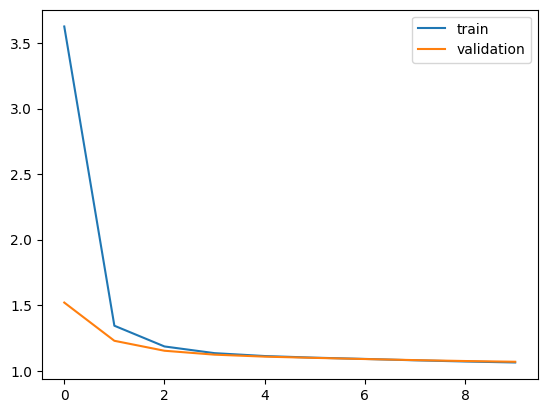

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

The model seems to have got a good fit on the dataset. Ready for predictions.

In [30]:
preds = model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1])))
# Convert probabilities to class labels
preds = np.argmax(preds, axis=-1)

157/157 [==============================] - 2s 5ms/step


**<h2> Detokenizing predicted sequences**

In the next few lines of code we will be detokenizing the sequences to get our predicted/translated sentences.

In [31]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [32]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenized)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenized)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t)

       preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})
pred_df.sample(20)

**<h2> Summary**

The English-French translator was made using the SeqtoSeq Model.
The accuracy achieved with 10 epochs was 84.64% on training set and 84.55% on dev set, which indicates low variance and low bias.
This model can now be successfully used for conversion of english to french sentences.
